Analysis and Visualization of WikiSRAT data
===

In this notebook, we create interactive visualizations of data in the WikiSRAT database.

Run within a conda environment specified in the included `environment.yml` file. 

Create the environment with either the Import button on Anaconda Navigator's Environments tab, or this Conda command in your terminal or console, replacing `path/environment.yml` with the full file pathway to the environment.yml file in the local cloned repository.

```bash
conda env create --file path/environment.yml
```

To update your environment, either use Anaconda Navigator, or run the following command:

```bash
conda env update --file path/environment.yml --prune
```

or

```bash
conda env create --file path/environment.yml --force
```

# Setup
* Import packages
* Load data from parquet files

In [1]:
# packages for data requests
import requests
import pandas as pd
from requests.auth import HTTPBasicAuth
import json
import os
import psycopg2

from pathlib import Path

# packages for viz 
import matplotlib.pyplot as plt
# from pynhd import NLDI, WaterData, NHDPlusHR
# import pynhd as nhd
import geopandas as gpd
import plotly.express as px

# import geoviews as gv
# import geoviews.feature as gf
# from geoviews import opts
# from cartopy import crs 
# import geoviews.tile_sources as gts
# gv.extension('bokeh', 'matplotlib')
# import hvplot.pandas


In [2]:
# Find current working directory
Path.cwd()

PosixPath('/Users/aaufdenkampe/Documents/Python/WikiSRATMicroService')

In [3]:
# username = "Sarah"
username = "Anthony"

In [4]:
# Set alternate project & data folders
if username == "Anthony":
    project_folder = Path('/Users/aaufdenkampe/Documents/Python/WikiSRATMicroService')
elif username == "Sarah":
    project_folder = Path('C:/Users/sjordan/Documents/Python/WikiSRATMicroService')
data_folder    = Path('data/')

## Read Parquet File

In [6]:
base_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 19496 entries, 4149942 to 4150466
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   tploadrate_total      19496 non-null  float64 
 1   tploadate_conc        19496 non-null  float64 
 2   tnloadrate_total      19496 non-null  float64 
 3   tnloadate_conc        19496 non-null  float64 
 4   tssloadrate_total     19496 non-null  float64 
 5   tssloadate_conc       19496 non-null  float64 
 6   catchment_hectares    19496 non-null  float64 
 7   watershed_hectares    19496 non-null  float64 
 8   tploadrate_total_ws   19496 non-null  float64 
 9   tnloadrate_total_ws   19496 non-null  float64 
 10  tssloadrate_total_ws  19496 non-null  float64 
 11  maflowv               19496 non-null  float64 
 12  geom                  19266 non-null  geometry
 13  geom_catchment        19496 non-null  geometry
 14  cluster               17358 non-null  

In [38]:
base_gdf

,tploadrate_total,tploadate_conc,tnloadrate_total,tnloadate_conc,tssloadrate_total,tssloadate_conc,catchment_hectares,watershed_hectares,tploadrate_total_ws,tnloadrate_total_ws,tssloadrate_total_ws,maflowv,geom,geom_catchment,cluster,fa_name,sub_focusarea,nord,nordstop,huc12
comid,,,,,,,,,,,,,,,,,,,,
4149942,19.8106,0.0199,461.7835,0.4635,23315.2162,23.4000,199.4606,199.62,0.0993,2.3135,116.7978,1.115,MULTILINESTRING Z ((506490.373 4594278.694 0.0...,"MULTIPOLYGON (((506092.122 4593422.061, 506098...",Poconos and Kittatinny,None,NaN,72392.0,72392.0,020401040504
4151440,0.0037,0.0120,0.0679,0.2181,6.6330,12.7636,0.0899,5049.90,0.0758,1.3784,80.6635,35.714,MULTILINESTRING Z ((514920.168 4587490.302 0.0...,"MULTIPOLYGON (((514955.572 4587467.785, 514926...",Poconos and Kittatinny,None,NaN,72128.0,72165.0,020401040504
4150082,2.0144,0.0099,25.4212,0.1405,4910.5669,22.9938,45.1439,69.21,0.0490,0.6948,113.7074,0.383,MULTILINESTRING Z ((502865.583 4590886.516 0.0...,"MULTIPOLYGON (((502581.690 4590660.525, 502522...",Poconos and Kittatinny,None,NaN,72440.0,72441.0,020401040504
4151394,2.9297,-9999.0000,58.2131,-9999.0000,5942.7803,-9999.0000,11.8705,697436.01,-54432.3165,-54432.3165,-54432.3165,4248.704,MULTILINESTRING Z ((507356.841 4591522.967 0.0...,"MULTIPOLYGON (((507205.238 4591376.554, 507218...",Poconos and Kittatinny,None,NaN,72338.0,74971.0,020401040504
4149944,0.2212,0.0199,1.7217,0.4623,714.6338,23.9081,1.3489,200.97,0.0993,2.3064,119.2765,1.122,MULTILINESTRING Z ((506039.307 4593540.381 0.0...,"MULTIPOLYGON (((506092.122 4593422.061, 505974...",Poconos and Kittatinny,None,NaN,72391.0,72392.0,020401040504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4150260,1.2717,0.0147,17.4586,0.3105,3213.5741,24.8598,10.1619,488.88,0.0878,1.8542,148.4542,3.267,MULTILINESTRING Z ((511901.572 4588245.373 0.0...,"MULTIPOLYGON (((512065.727 4588106.375, 512006...",Poconos and Kittatinny,None,NaN,72178.0,72180.0,020401040504
4151474,0.0276,0.0154,0.6812,0.2186,42.7999,33.5127,0.6295,2902.50,0.1018,1.4445,221.4500,21.463,MULTILINESTRING Z ((509331.221 4587357.849 0.0...,"MULTIPOLYGON (((509438.231 4587314.755, 509379...",Poconos and Kittatinny,None,NaN,72182.0,72195.0,020401040504
4150526,18.9184,0.0145,479.5846,0.3683,23384.0050,17.9602,213.8491,214.02,0.0882,2.2406,109.2608,1.457,MULTILINESTRING Z ((506372.886 4582303.869 0.0...,"MULTIPOLYGON (((505993.004 4581580.731, 505934...",Poconos and Kittatinny,None,NaN,72191.0,72191.0,020401040504


In [ ]:
base_gdf

In [9]:
# define catchments as the geometry used by GeoPandas
base_gdf_catch = gpd.GeoDataFrame(base_gdf, geometry="geom_catchment")
rest_gdf_catch = gpd.GeoDataFrame(rest_gdf, geometry="geom_catchment")

In [10]:
rest_gdf_catch.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 19496 entries, 2612952 to 8409235
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   tploadrate_total      19496 non-null  float64 
 1   tploadate_conc        19496 non-null  float64 
 2   tnloadrate_total      19496 non-null  float64 
 3   tnloadate_conc        19496 non-null  float64 
 4   tssloadrate_total     19496 non-null  float64 
 5   tssloadate_conc       19496 non-null  float64 
 6   catchment_hectares    19496 non-null  float64 
 7   watershed_hectares    19496 non-null  float64 
 8   tploadrate_total_ws   19496 non-null  float64 
 9   tnloadrate_total_ws   19496 non-null  float64 
 10  tssloadrate_total_ws  19496 non-null  float64 
 11  maflowv               19496 non-null  float64 
 12  geom                  19266 non-null  geometry
 13  geom_catchment        19496 non-null  geometry
 14  cluster               17358 non-null  

In [15]:
rest_gdf_catch.index

Int64Index([ 2612952,  2612782,  2612920,  2613460,  2612780,  2612792,
             2612956,  2612794,  2612948,  2612950,
            ...
             9437009, 26814149,  9437007,  9437021,  9436995,  9437027,
             9437011,  9436999,  8409259,  8409235],
           dtype='int64', name='comid', length=19496)

In [40]:
# Example selecting by comid, which is the row index
base_gdf.loc[4648450]

tploadrate_total                                                 375.8633
tploadate_conc                                                     0.2979
tnloadrate_total                                                5789.5674
tnloadate_conc                                                     4.5884
tssloadrate_total                                             205160.7942
tssloadate_conc                                                  162.5966
catchment_hectares                                               263.4373
watershed_hectares                                                 263.61
tploadrate_total_ws                                                1.4259
tnloadrate_total_ws                                               21.9625
tssloadrate_total_ws                                             778.2738
maflowv                                                             1.412
geom                    (LINESTRING Z (422951.8280493749 4441126.60863...
geom_catchment          (POLYGON ((423

In [42]:
base_gdf.loc[4648450].tploadrate_total / base_gdf.loc[4648450].catchment_hectares 

1.4267656858007578

In [43]:
rest_gdf.loc[4648450]

tploadrate_total                                                 375.8633
tploadate_conc                                                     0.2979
tnloadrate_total                                                5789.5674
tnloadate_conc                                                     4.5884
tssloadrate_total                                             205160.7942
tssloadate_conc                                                  162.5966
catchment_hectares                                               263.4373
watershed_hectares                                                 263.61
tploadrate_total_ws                                                1.4259
tnloadrate_total_ws                                               21.9625
tssloadrate_total_ws                                             778.2738
maflowv                                                             1.412
geom                    (LINESTRING Z (422951.8280493749 4441126.60863...
geom_catchment          (POLYGON ((423

In [36]:
base_gdf.tploadrate_total.min()

0.0003

In [37]:
base_gdf.tploadrate_total.max()

266503.8003

In [ ]:
%%time
# read data from parquet files
base_gdf = gpd.read_parquet(project_folder / data_folder /'base_df.parquet')
rest_gdf = gpd.read_parquet(project_folder / data_folder /'rest_df.parquet')

CPU times: user 1.84 s, sys: 233 ms, total: 2.07 s
Wall time: 2.02 s


# Static Plots 

Plot with GeoPandas

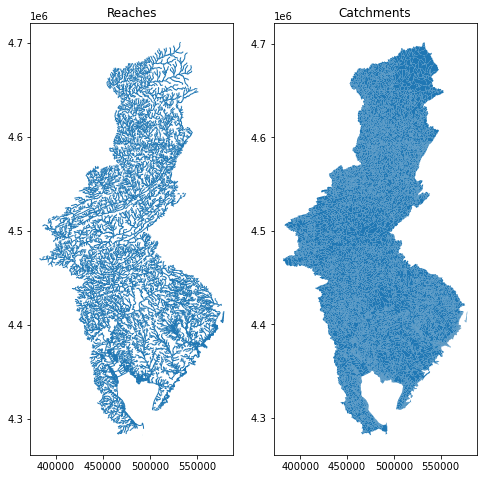

CPU times: user 5.83 s, sys: 29.4 ms, total: 5.86 s
Wall time: 5.48 s


In [18]:
%%time
fig, (ax1, ax2) = plt.subplots(1,2)
base_gdf.plot(lw=1, ax=ax1)
base_gdf_catch.plot(lw=0.1, ax=ax2)
fig.set_size_inches(8,8)
ax1.set_title("Reaches")
ax2.set_title("Catchments")
plt.show()

## Plot by Reach & Catchment Values

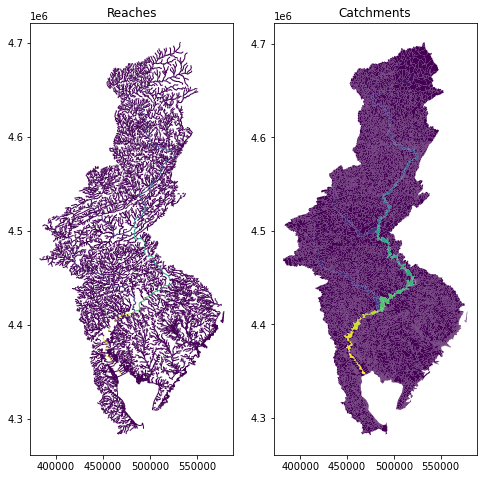

CPU times: user 5.92 s, sys: 21.8 ms, total: 5.94 s
Wall time: 5.56 s


In [21]:
%%time
# Plot colors by values of Mean Annual Flow Volumentric (`maflowv`)
fig, (ax1, ax2) = plt.subplots(1,2)
base_gdf.plot(column = 'maflowv', lw=1, ax=ax1)
base_gdf_catch.plot(column = 'maflowv', lw=0.1, ax=ax2)
fig.set_size_inches(8,8)
ax1.set_title("Reaches")
ax2.set_title("Catchments")
plt.show()

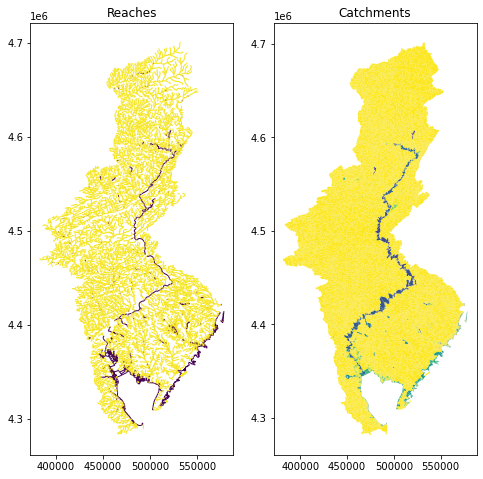

CPU times: user 5.94 s, sys: 21.7 ms, total: 5.96 s
Wall time: 5.57 s


In [26]:
%%time
# Plot colors by values of Total Phosphorus concentrations & Load Rates
fig, (ax1, ax2) = plt.subplots(1,2)
base_gdf.plot(column = 'tploadate_conc', lw=1, ax=ax1)
base_gdf_catch.plot(column = 'tploadrate_total_ws', lw=0.1, ax=ax2)
fig.set_size_inches(8,8)
ax1.set_title("Reaches")
ax2.set_title("Catchments")
plt.show()

## Plot by Cluster and Focus Area

Notes from Mike & Lin:
- DRWI projects have only been implemented in Focus Areas
- `fa_name` has changed over time
  - We're using Phase 2+ name
- We should present info at the smallest scale
  - Show "Paulins Kill" Focus Area, where all the projects are in and the FA is "saturatated" with projects 
- Pour Points = `cluster.fa_name.sub_focusarea` 

In [22]:
base_gdf_catch.cluster.unique()

array(['Poconos and Kittatinny', 'drb', 'Kirkwood - Cohansey Aquifer',
       'New Jersey Highlands', 'Upper Lehigh', 'Schuylkill Highlands',
       'Upstream Suburban Philadelphia', 'Middle Schuylkill',
       'Brandywine and Christina', None], dtype=object)

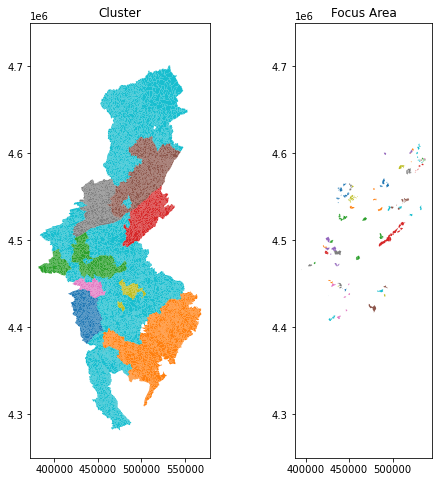

In [23]:
# color by cluster 
fig, (ax1, ax2) = plt.subplots(1,2)
base_gdf_catch[base_gdf_catch.cluster != 'None'].plot(column = 'cluster', lw=0.1, ax=ax1)
base_gdf_catch[base_gdf_catch.cluster != 'None'].plot(column = 'fa_name', lw=0.1, ax=ax2)

fig.set_size_inches(8,8)
ax1.set_title("Cluster")
ax2.set_title("Focus Area")
for ax in [ax1, ax2]:
    ax.set_ylim(4.25 * 10**6, 4.75 * 10**6)
plt.show()

# Dynamic Plots

## px.chloropleth_mapbox

Un-comment out cells below to commit -- otherwise, the files are too large.

https://stackoverflow.com/questions/46891914/control-mapbox-extent-in-plotly-python-api

Remove borders: https://stackoverflow.com/questions/61420022/plotly-choropleth-without-borders

In [29]:
# project for plotly
base_gdf_proj = base_gdf.to_crs(epsg=4326)
base_gdf_catch_proj = base_gdf_catch.to_crs(epsg=4326)

In [31]:
base_gdf_proj

,tploadrate_total,tploadate_conc,tnloadrate_total,tnloadate_conc,tssloadrate_total,tssloadate_conc,catchment_hectares,watershed_hectares,tploadrate_total_ws,tnloadrate_total_ws,tssloadrate_total_ws,maflowv,geom,geom_catchment,cluster,fa_name,sub_focusarea,nord,nordstop,huc12
comid,,,,,,,,,,,,,,,,,,,,
4149942,19.8106,0.0199,461.7835,0.4635,23315.2162,23.4000,199.4606,199.62,0.0993,2.3135,116.7978,1.115,MULTILINESTRING Z ((-74.92224 41.50010 0.00000...,"MULTIPOLYGON (((506092.122 4593422.061, 506098...",Poconos and Kittatinny,None,NaN,72392.0,72392.0,020401040504
4151440,0.0037,0.0120,0.0679,0.2181,6.6330,12.7636,0.0899,5049.90,0.0758,1.3784,80.6635,35.714,MULTILINESTRING Z ((-74.82140 41.43885 0.00000...,"MULTIPOLYGON (((514955.572 4587467.785, 514926...",Poconos and Kittatinny,None,NaN,72128.0,72165.0,020401040504
4150082,2.0144,0.0099,25.4212,0.1405,4910.5669,22.9938,45.1439,69.21,0.0490,0.6948,113.7074,0.383,MULTILINESTRING Z ((-74.96568 41.46957 0.00000...,"MULTIPOLYGON (((502581.690 4590660.525, 502522...",Poconos and Kittatinny,None,NaN,72440.0,72441.0,020401040504
4151394,2.9297,-9999.0000,58.2131,-9999.0000,5942.7803,-9999.0000,11.8705,697436.01,-54432.3165,-54432.3165,-54432.3165,4248.704,MULTILINESTRING Z ((-74.91189 41.47527 0.00000...,"MULTIPOLYGON (((507205.238 4591376.554, 507218...",Poconos and Kittatinny,None,NaN,72338.0,74971.0,020401040504
4149944,0.2212,0.0199,1.7217,0.4623,714.6338,23.9081,1.3489,200.97,0.0993,2.3064,119.2765,1.122,MULTILINESTRING Z ((-74.92765 41.49346 0.00000...,"MULTIPOLYGON (((506092.122 4593422.061, 505974...",Poconos and Kittatinny,None,NaN,72391.0,72392.0,020401040504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4150260,1.2717,0.0147,17.4586,0.3105,3213.5741,24.8598,10.1619,488.88,0.0878,1.8542,148.4542,3.267,MULTILINESTRING Z ((-74.85752 41.44570 0.00000...,"MULTIPOLYGON (((512065.727 4588106.375, 512006...",Poconos and Kittatinny,None,NaN,72178.0,72180.0,020401040504
4151474,0.0276,0.0154,0.6812,0.2186,42.7999,33.5127,0.6295,2902.50,0.1018,1.4445,221.4500,21.463,MULTILINESTRING Z ((-74.88831 41.43774 0.00000...,"MULTIPOLYGON (((509438.231 4587314.755, 509379...",Poconos and Kittatinny,None,NaN,72182.0,72195.0,020401040504
4150526,18.9184,0.0145,479.5846,0.3683,23384.0050,17.9602,213.8491,214.02,0.0882,2.2406,109.2608,1.457,MULTILINESTRING Z ((-74.92377 41.39224 0.00000...,"MULTIPOLYGON (((505993.004 4581580.731, 505934...",Poconos and Kittatinny,None,NaN,72191.0,72191.0,020401040504


In [34]:
base_gdf_proj.index

Int64Index([  4149942,   4151440,   4150082,   4151394,   4149944,   4150436,
              4150464,   4151392,   4150226,   4150518,
            ...
            932040262,   4150192,   2619260,   4188139,   4151472,   4150260,
              4151474,   4150526,   4151464,   4150466],
           dtype='int64', name='comid', length=19496)

In [87]:
# %%time
# fig = px.choropleth_mapbox(base_gdf_catch_proj,
#                            geojson=base_gdf_catch_proj.geom_catchment,
#                            locations=base_gdf_catch_proj.index,
#                            color='maflowv',
#                            color_continuous_scale="Viridis",
#                            # range_color=(0, 12),
#                            # width=200,
#                            mapbox_style="carto-positron",
#                            zoom=6,
#                            center = {"lat": 40.4604, "lon": -74.8334},
#                            opacity=0.5,
#                            height = 500,
#                            # width = 100
#                            labels={'Comid':'comid'}
#                           )
# fig.update_traces(marker_line_color='rgba(255,255,255,0)', selector=dict(type='choroplethmapbox')) #make the border transparent
# fig.update_layout(margin={"r":300,"t":0,"l":300,"b":0})
# # fig['layout']['geo']['subunitcolor']='rgba(0,0,0,0)'

# fig.show()

## Plotting multiline

Extract latitudes and longitudes -- this is not great in plotly.

Maybe utlimately try something with bokeh and geopandas?
https://kodu.ut.ee/~kmoch/geopython2018/lessons/L5/interactive-map-bokeh.html

In [30]:
%%time

# plot lines https://plotly.com/python/lines-on-mapbox/
import numpy as np

lats = []
lons = []
names = []
colors = []

i = 0 
tot = len(base_gdf.geom)

for feature, name, mfv in zip(base_gdf_proj.geom, base_gdf_proj.comid, base_gdf_proj.maflowv):

    if feature == None:
        pass
    else:
        linestrings = feature


        for linestring in linestrings:
            x, y = linestring.xy
            lats.extend(y)
            lons.extend(x)
            names.extend([name]*len(y))
            colors.extend([mfv]*len(y))
            lats.extend([None])
            lons.extend([None])
            names.extend([None])
            colors.extend([None])
    pct = round(i / tot * 100, 2)
    if pct % 10 == 0:
        print(str(pct) + "% done") 
    i += 1

AttributeError: 'GeoDataFrame' object has no attribute 'comid'

NOTE: Sarah, this function above might be made much more efficient by avoiding the use of np.append() inside the loop. If I remember, np.append is very slow because it reallocates memory each time. List append is very fast, however, so its often recommened in these cases to create a list using the loop, then convert that list into an array in one final step.

Anthony: done, much faster. 

In [88]:
# %%time
# fig = px.line_mapbox(lat=lats, lon=lons, hover_name=names,
#                      mapbox_style="carto-positron",
#                      # color=colors,
#                      zoom=6,
#                      center = {"lat": 40.4604, "lon": -74.8334},
#                      height=500
#                     )
# fig.update_layout(margin={"r":300,"t":0,"l":300,"b":0})
# fig.show()

In [22]:
len(colors) == len(lats)

True

## go.Chloroplethmapbox

Different option within plotly, which includes option to remove borders:
* https://plotly.com/python/mapbox-county-choropleth/

In [23]:
# set up for chloropleth map 
geo_df_g2_json = json.loads(base_gdf_.to_json())

In [89]:
# %%time
# import plotly.graph_objects as go

# token = "pk.eyJ1Ijoic2pvcmRhbjI5IiwiYSI6ImNrc3Jzb2Y4ODBwbTYybnA3MjloZ2RjMHcifQ.6IVtsCFcLvhLFNl_IF9OqA"
# fig = go.Figure(go.Choroplethmapbox(geojson=geo_df_g2_json,
#                                     locations=base_gpd.index,
#                                     z = base_gpd['maflowv'],
#                                     colorscale="Viridis",
#                                     marker_line_width=0,
# #                                   #  height
#                                    ))
# fig.update_layout(mapbox_style="light", mapbox_accesstoken=token,
#                   mapbox_zoom=6, mapbox_center = {"lat": 40.4604, "lon": -74.8334})
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

# Next steps
* Drop down menus - maybe (low priority)
* Add polylines to plotly map? 
* Flip on and off different features?

Questions:
* units? Got them
* Does Mike have info on larger geographic areas and their relaton to comids? Yes, done

Future next steps:
* Arithmetic on columns 
* Organized efforts into geographic **clusters** --> **focus areas**  --> **pour points** --> Done. 
* HUC12 (similar map)

**Units:** 
* Concentration: mg/L
* loadrate_totals: kg/yr
* loadrate_total_ws: attempt to get loadrate totals to kg/ha: fails if mean annual flow doesn't exist = ((loadate_conc * 28.3168 * 31557600 / 1000000) * maflowv) / watershed_hectares 